# Embedding, LSTM, GRU and Conv1D
Cognitive Systems for Health Technology Applications<br>
8.3.2019, Sakari Lukkarinen<br>
[Helsinki Metropolia University of Applied Sciences](https://www.metropolia.fi/en)


## Objectives
The aim of this Notebook is to show how to use keras embedding layers together with LSTM, GRU and Conv1D layers to classify review converted to sequences. 

The examples are following the structure given in book: Chollet, Deep Learning with Python, Ch. 6. Deep learning for text and sequences. The examples are not optimized but the aim is to show how to configure the model architectures.

## Data preparation

In [6]:
# Read basic libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
print(os.listdir("../../case3_datas"))


['drugsComTest_raw.csv', 'drugsComTrain_raw.csv']


In [7]:
# Read the training data
# Create dataframes train and test
test = pd.read_csv(r"../../case3_datas/drugsComTest_raw.csv")
train = pd.read_csv(r"../../case3_datas/drugsComTrain_raw.csv")
print(train)

        uniqueID                            drugName  \
0         206461                           Valsartan   
1          95260                          Guanfacine   
2          92703                              Lybrel   
3         138000                          Ortho Evra   
4          35696            Buprenorphine / naloxone   
5         155963                              Cialis   
6         165907                      Levonorgestrel   
7         102654                        Aripiprazole   
8          74811                              Keppra   
9          48928  Ethinyl estradiol / levonorgestrel   
10         29607                          Topiramate   
11         75612                      L-methylfolate   
12        191290                             Pentasa   
13        221320                    Dextromethorphan   
14         98494                           Nexplanon   
15         81890                         Liraglutide   
16         48188                        Trimetho

In [8]:
# Show the head of the data
train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [9]:
# Create labels based on the original article: Grässer et al. (2018)
r = train['rating']
labels = -1*(r <= 4) + 1*(r >= 7)
# Add the label column to the data
train['label'] = labels
# Check the new data
train.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,label
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,1
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,1
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,0
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10,1
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,1


In [10]:
# Check ratings to labels conversion
import matplotlib.pyplot as plt
train.plot(x = 'rating', y = 'label', kind = 'scatter')
plt.show()

<Figure size 640x480 with 1 Axes>

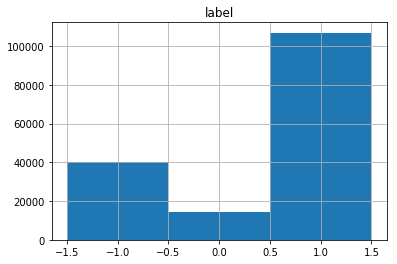

In [11]:
# Plot distribution of labels
train.hist(column = 'label', bins = np.arange(-1, 3), align = 'left');

## Convert reviews to padded sequences

In [12]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# Read a part of the reviews and create training sequences (x_train)
samples = train['review'].iloc[:10000]
tokenizer = Tokenizer(num_words = 1000)
tokenizer.fit_on_texts(samples)
sequences = tokenizer.texts_to_sequences(samples)
x_train = pad_sequences(sequences, maxlen = 500)

Using TensorFlow backend.


## Convert labels to one-hot-categories

In [13]:
from keras.utils import to_categorical

# Convert the labels to one_hot_category values
one_hot_labels = to_categorical(labels[:10000], num_classes = 3)

## Check the shapes

In [14]:
# Check the training and label sets
x_train.shape, one_hot_labels.shape

((10000, 500), (10000, 3))

## Helper functions

In [15]:
# We use the same plotting commands several times, so create a function for that purpose
def plot_history(history):
    
    f, ax = plt.subplots(1, 2, figsize = (16, 7))
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.sca(ax[0])
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.sca(ax[1])
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [16]:
# Similarly create a function for model training, for demonstration purposes we use constant values
def train_model(model, x, y, e = 10, bs = 32, v = 1, vs = 0.25):
    h = model.fit(x, y, epochs = e, batch_size = bs, verbose = v, validation_split = vs)
    return h

## Example 1 - Embedding and Flatten

In [17]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

# First model: Embedding layer -> Flatten -> Dense classifier
m0 = Sequential()
m0.add(Embedding(1000, 64, input_length = 500)) # 1000 = num_words, 64 = Embedding layers, 500 = sequence length
m0.add(Flatten())
m0.add(Dense(32, activation = 'relu'))
m0.add(Dense(3, activation = 'softmax'))
m0.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m0.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 64)           64000     
_________________________________________________________________
flatten_1 (Flatten)          (None, 32000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1024032   
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 99        
Total params: 1,088,131
Trainable params: 1,088,131
Non-trainable params: 0
_________________________________________________________________


Train on 7500 samples, validate on 2500 samples
Epoch 1/10
7500/7500 [==============================] - 4s 520us/step - loss: 0.8208 - acc: 0.6704 - val_loss: 0.7371 - val_acc: 0.7296
Epoch 2/10
7500/7500 [==============================] - 4s 476us/step - loss: 0.5695 - acc: 0.7893 - val_loss: 0.6855 - val_acc: 0.7340
Epoch 3/10
7500/7500 [==============================] - 4s 490us/step - loss: 0.3804 - acc: 0.8624 - val_loss: 0.7585 - val_acc: 0.7156
Epoch 4/10
7500/7500 [==============================] - 4s 472us/step - loss: 0.2043 - acc: 0.9345 - val_loss: 0.9229 - val_acc: 0.7112
Epoch 5/10
7500/7500 [==============================] - 4s 472us/step - loss: 0.0959 - acc: 0.9709 - val_loss: 1.1478 - val_acc: 0.6552
Epoch 6/10
7500/7500 [==============================] - 4s 474us/step - loss: 0.0436 - acc: 0.9868 - val_loss: 1.4717 - val_acc: 0.6968
Epoch 7/10
7500/7500 [==============================] - 4s 467us/step - loss: 0.0223 - acc: 0.9937 - val_loss: 1.7233 - val_acc: 0.6968


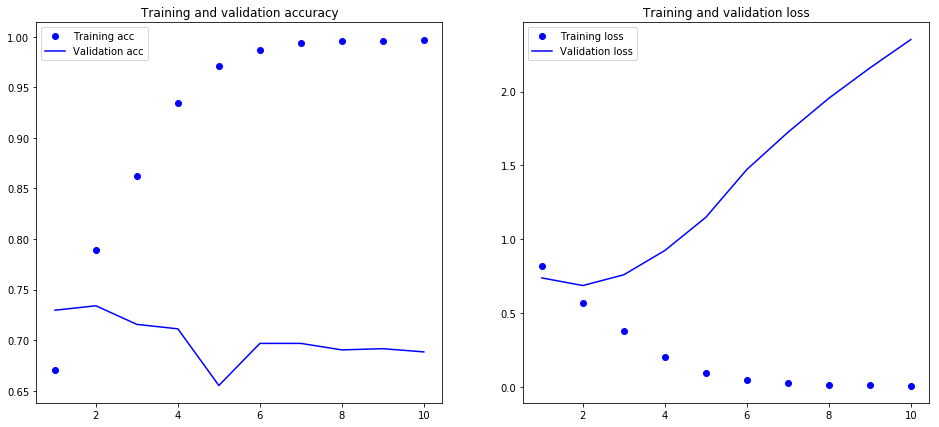

In [18]:
# Train the first model and plot the history
h0 = train_model(m0, x_train, one_hot_labels)
plot_history(h0)

## Example 2 - Embedding and LSTM

In [19]:
from keras.layers import LSTM

# Second model: Embedding -> LSTM -> Dense classifier
m1 = Sequential()
m1.add(Embedding(1000, 8, input_length = 500))
m1.add(LSTM(8))
m1.add(Dense(3, activation = 'softmax'))
m1.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 8)            8000      
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 544       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 27        
Total params: 8,571
Trainable params: 8,571
Non-trainable params: 0
_________________________________________________________________


Train on 7500 samples, validate on 2500 samples
Epoch 1/10
7500/7500 [==============================] - 29s 4ms/step - loss: 0.8397 - acc: 0.6589 - val_loss: 0.8246 - val_acc: 0.6560
Epoch 2/10
7500/7500 [==============================] - 29s 4ms/step - loss: 0.7333 - acc: 0.6891 - val_loss: 0.7202 - val_acc: 0.6976
Epoch 3/10
7500/7500 [==============================] - 30s 4ms/step - loss: 0.6829 - acc: 0.7336 - val_loss: 0.7077 - val_acc: 0.7260
Epoch 4/10
7500/7500 [==============================] - 48s 6ms/step - loss: 0.6502 - acc: 0.7561 - val_loss: 0.6837 - val_acc: 0.7400
Epoch 5/10
7500/7500 [==============================] - 28s 4ms/step - loss: 0.6268 - acc: 0.7655 - val_loss: 0.6713 - val_acc: 0.7412
Epoch 6/10
7500/7500 [==============================] - 28s 4ms/step - loss: 0.6130 - acc: 0.7703 - val_loss: 0.6961 - val_acc: 0.7396
Epoch 7/10
7500/7500 [==============================] - 28s 4ms/step - loss: 0.6022 - acc: 0.7764 - val_loss: 0.6897 - val_acc: 0.7224
Epoch 8

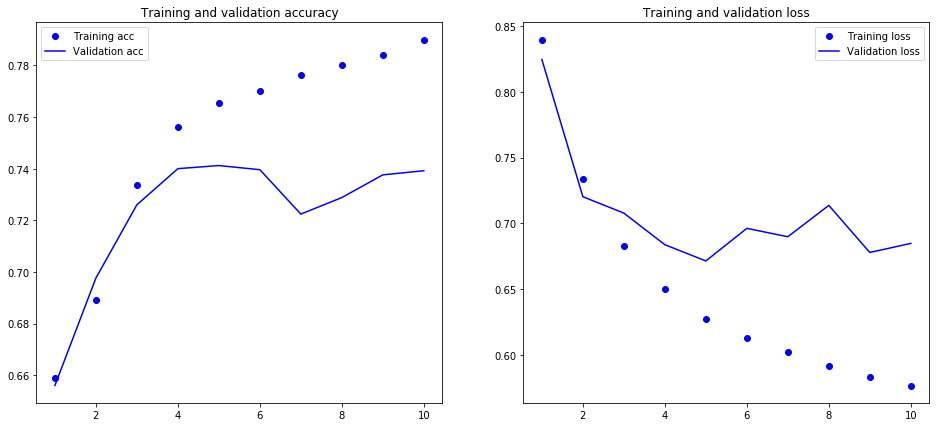

In [20]:
# Train the second model and plot the history
h1 = train_model(m1, x_train, one_hot_labels)
plot_history(h1)

## Example 3 - Embedding and GRU

In [21]:
from keras.layers import GRU

# Third model: Embedding -> GRU -> Dense classifier
m2 = Sequential()
m2.add(Embedding(1000, 8, input_length = 500))
m2.add(GRU(8))
m2.add(Dense(3, activation = 'softmax'))
m2.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 8)            8000      
_________________________________________________________________
gru_1 (GRU)                  (None, 8)                 408       
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 27        
Total params: 8,435
Trainable params: 8,435
Non-trainable params: 0
_________________________________________________________________


Train on 7500 samples, validate on 2500 samples
Epoch 1/10
7500/7500 [==============================] - 22s 3ms/step - loss: 0.9091 - acc: 0.6561 - val_loss: 0.8372 - val_acc: 0.6560
Epoch 2/10
7500/7500 [==============================] - 22s 3ms/step - loss: 0.8162 - acc: 0.6588 - val_loss: 0.8153 - val_acc: 0.6560
Epoch 3/10
7500/7500 [==============================] - 22s 3ms/step - loss: 0.7733 - acc: 0.6661 - val_loss: 0.7807 - val_acc: 0.6632
Epoch 4/10
7500/7500 [==============================] - 22s 3ms/step - loss: 0.7132 - acc: 0.7056 - val_loss: 0.7421 - val_acc: 0.6960
Epoch 5/10
7500/7500 [==============================] - 22s 3ms/step - loss: 0.6676 - acc: 0.7369 - val_loss: 0.7070 - val_acc: 0.7168
Epoch 6/10
7500/7500 [==============================] - 36s 5ms/step - loss: 0.6427 - acc: 0.7532 - val_loss: 0.6976 - val_acc: 0.7228
Epoch 7/10
7500/7500 [==============================] - 27s 4ms/step - loss: 0.6279 - acc: 0.7620 - val_loss: 0.6896 - val_acc: 0.7272
Epoch 8

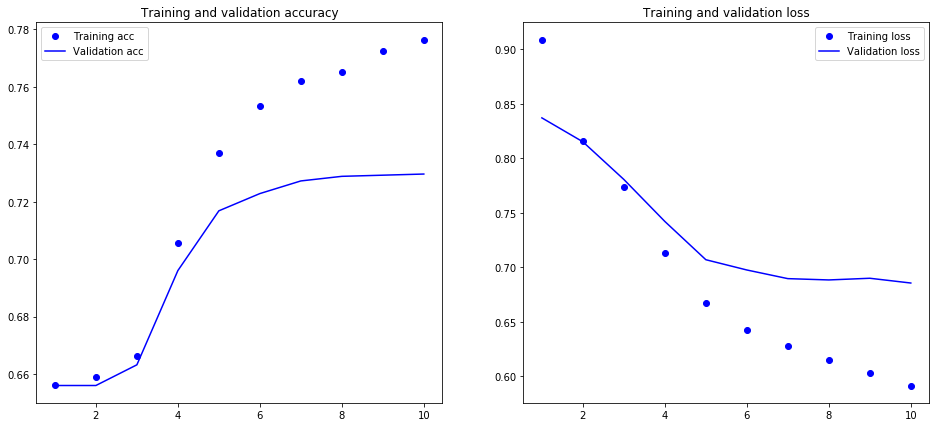

In [22]:
# Train the third model and plot the history
h2 = train_model(m2, x_train, one_hot_labels)
plot_history(h2)

## Example 4 - Embedding and GRU with dropout

In [23]:
# Fourth model: Embedding -> GRU with dropouts -> Dense classifier
m3 = Sequential()
m3.add(Embedding(1000, 8, input_length = 500))
m3.add(GRU(8, dropout = 0.2, recurrent_dropout = 0.2))
m3.add(Dense(3, activation = 'softmax'))
m3.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 8)            8000      
_________________________________________________________________
gru_2 (GRU)                  (None, 8)                 408       
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 27        
Total params: 8,435
Trainable params: 8,435
Non-trainable params: 0
_________________________________________________________________


Train on 7500 samples, validate on 2500 samples
Epoch 1/10
7500/7500 [==============================] - 28s 4ms/step - loss: 0.8801 - acc: 0.6564 - val_loss: 0.8270 - val_acc: 0.6560
Epoch 2/10
7500/7500 [==============================] - 28s 4ms/step - loss: 0.8000 - acc: 0.6604 - val_loss: 0.7938 - val_acc: 0.6564
Epoch 3/10
7500/7500 [==============================] - 28s 4ms/step - loss: 0.7602 - acc: 0.6823 - val_loss: 0.7745 - val_acc: 0.6732
Epoch 4/10
7500/7500 [==============================] - 28s 4ms/step - loss: 0.7247 - acc: 0.7108 - val_loss: 0.7620 - val_acc: 0.6768
Epoch 5/10
7500/7500 [==============================] - 28s 4ms/step - loss: 0.7037 - acc: 0.7232 - val_loss: 0.7517 - val_acc: 0.6892
Epoch 6/10
7500/7500 [==============================] - 28s 4ms/step - loss: 0.6946 - acc: 0.7304 - val_loss: 0.7531 - val_acc: 0.6900
Epoch 7/10
7500/7500 [==============================] - 28s 4ms/step - loss: 0.6869 - acc: 0.7339 - val_loss: 0.7431 - val_acc: 0.6972
Epoch 8

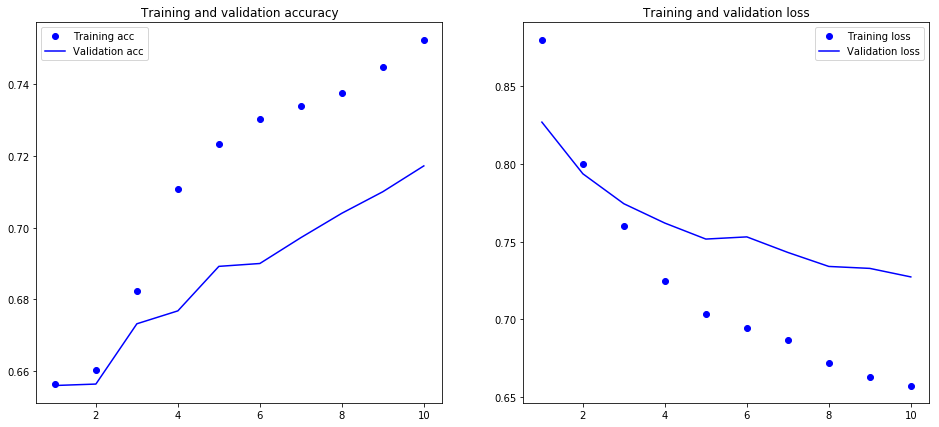

In [24]:
# Train and plot the history
h3 = train_model(m3, x_train, one_hot_labels)
plot_history(h3)

## Example 5 - Embedding and stack of GRUs

In [25]:
# Fifth model: Embedding -> Stack of GRU layers -> Dense classifier
m4 = Sequential()
m4.add(Embedding(1000, 8, input_length = 500))
m4.add(GRU(8, dropout = 0.1, recurrent_dropout = 0.5, return_sequences = True))
m4.add(GRU(8, activation = 'relu', dropout = 0.1, recurrent_dropout = 0.5))
m4.add(Dense(3, activation = 'softmax'))
m4.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m4.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 8)            8000      
_________________________________________________________________
gru_3 (GRU)                  (None, 500, 8)            408       
_________________________________________________________________
gru_4 (GRU)                  (None, 8)                 408       
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 27        
Total params: 8,843
Trainable params: 8,843
Non-trainable params: 0
_________________________________________________________________


Train on 7500 samples, validate on 2500 samples
Epoch 1/10
7500/7500 [==============================] - 56s 7ms/step - loss: 0.9130 - acc: 0.6568 - val_loss: 0.8425 - val_acc: 0.6560
Epoch 2/10
7500/7500 [==============================] - 54s 7ms/step - loss: 0.8287 - acc: 0.6588 - val_loss: 0.8191 - val_acc: 0.6560
Epoch 3/10
7500/7500 [==============================] - 54s 7ms/step - loss: 0.7920 - acc: 0.6616 - val_loss: 0.7930 - val_acc: 0.6608
Epoch 4/10
7500/7500 [==============================] - 55s 7ms/step - loss: 0.7548 - acc: 0.6895 - val_loss: 0.7788 - val_acc: 0.6752
Epoch 5/10
7500/7500 [==============================] - 54s 7ms/step - loss: 0.7317 - acc: 0.7088 - val_loss: 0.7681 - val_acc: 0.6768
Epoch 6/10
7500/7500 [==============================] - 55s 7ms/step - loss: 0.7191 - acc: 0.7139 - val_loss: 0.7654 - val_acc: 0.6828
Epoch 7/10
7500/7500 [==============================] - 54s 7ms/step - loss: 0.7003 - acc: 0.7260 - val_loss: 0.7613 - val_acc: 0.6868
Epoch 8

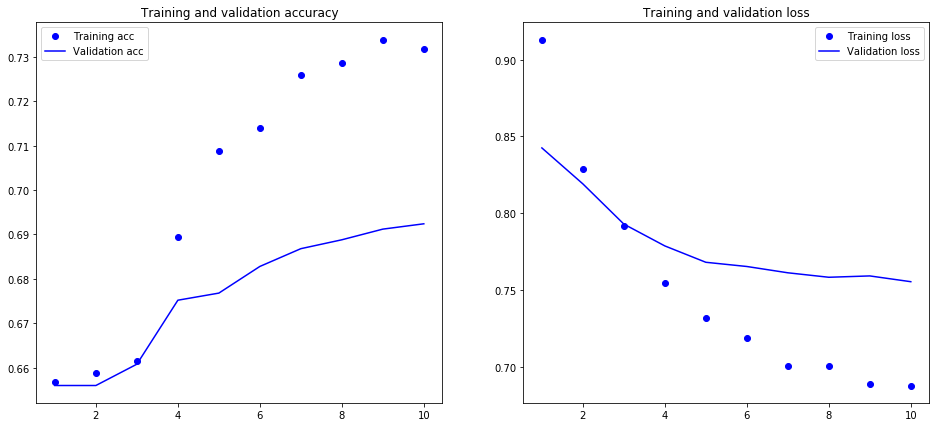

In [26]:
# Train and plot the history
h4 = train_model(m4, x_train, one_hot_labels)
plot_history(h4)

## Example 6 - Embedding and Conv1D

In [27]:
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D

# Sixth model: Embedding -> Conv1D & MaxPooling1D -> Dense classifier
m5 = Sequential()
m5.add(Embedding(1000, 32, input_length = 500))
m5.add(Conv1D(32, 7, activation = 'relu'))
m5.add(MaxPooling1D(5))
m5.add(Conv1D(32, 7, activation = 'relu'))
m5.add(GlobalMaxPooling1D())
m5.add(Dense(3, activation = 'softmax'))
m5.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 32)           32000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 494, 32)           7200      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 99        
Total params: 46,499
Trainable params: 46,499
Non-trainable params: 0
_________________________________________________________________


Train on 7500 samples, validate on 2500 samples
Epoch 1/10
7500/7500 [==============================] - 6s 756us/step - loss: 0.8368 - acc: 0.6575 - val_loss: 0.8123 - val_acc: 0.6560
Epoch 2/10
7500/7500 [==============================] - 5s 710us/step - loss: 0.7350 - acc: 0.6949 - val_loss: 0.7454 - val_acc: 0.6968
Epoch 3/10
7500/7500 [==============================] - 5s 712us/step - loss: 0.6466 - acc: 0.7493 - val_loss: 0.7157 - val_acc: 0.7196
Epoch 4/10
7500/7500 [==============================] - 5s 723us/step - loss: 0.6011 - acc: 0.7685 - val_loss: 0.7051 - val_acc: 0.7272
Epoch 5/10
7500/7500 [==============================] - 5s 706us/step - loss: 0.5647 - acc: 0.7865 - val_loss: 0.6997 - val_acc: 0.7340
Epoch 6/10
7500/7500 [==============================] - 5s 706us/step - loss: 0.5239 - acc: 0.8036 - val_loss: 0.7491 - val_acc: 0.7012
Epoch 7/10
7500/7500 [==============================] - 5s 704us/step - loss: 0.4803 - acc: 0.8205 - val_loss: 0.7203 - val_acc: 0.7292


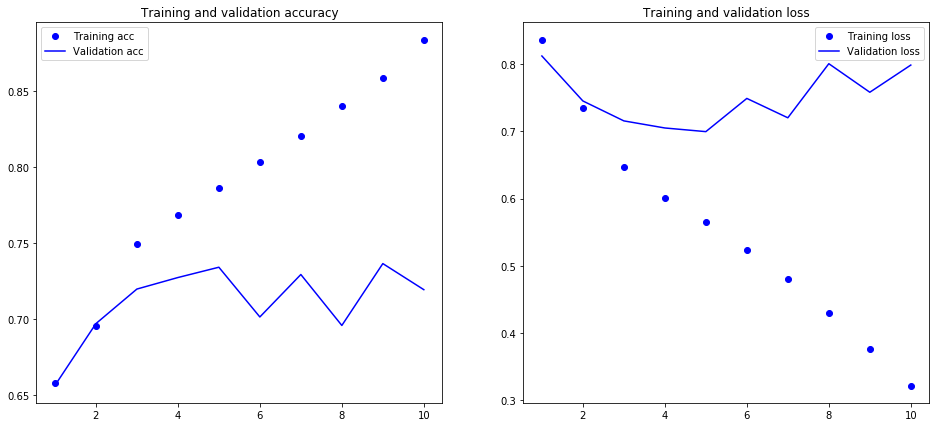

In [28]:
# Train and plot the history
h5 = train_model(m5, x_train, one_hot_labels)
plot_history(h5)

## Example 7 - Embedding and mixed Conv1D and GRU

In [29]:
# Seventh model: Embedding -> 2 x Conv1D + MaxPooling -> GRU -> Dense
m6 = Sequential()
m6.add(Embedding(1000, 32, input_length = 500))
m6.add(Conv1D(32, 5, activation = 'relu'))
m6.add(MaxPooling1D(5))
m6.add(Conv1D(32, 7, activation = 'relu'))
m6.add(GRU(8, dropout = 0.1, recurrent_dropout = 0.5))
m6.add(Dense(3, activation = 'softmax'))
m6.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['acc'])
m6.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 500, 32)           32000     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 496, 32)           5152      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 99, 32)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 93, 32)            7200      
_________________________________________________________________
gru_5 (GRU)                  (None, 8)                 984       
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 27        
Total params: 45,363
Trainable params: 45,363
Non-trainable params: 0
_________________________________________________________________


# Train and plot the history
h6 = train_model(m6, x_train, one_hot_labels)
plot_history(h6)

In [30]:
h6 = train_model(m6, x_train, one_hot_labels) plot_history(h6)

SyntaxError: invalid syntax (<ipython-input-30-29a96d09dcff>, line 1)